# Background Subtraction as an Optimization Problem

## Running This Notebook

### Setup
* Clone the [git repo](https://github.com/dmh43/background-subtraction) to a local directory.
* Update the `project_path` variable name below to the root of the project.
* Download video data from [here](http://www.ee.oulu.fi/~xliu/research/lsd/LSD.html).
* Install SPAMS from: [here](https://github.com/conda-forge/python-spams-feedstock) (if you use anaconda) or [here](http://spams-devel.gforge.inria.fr/downloads.html).
* Run `pip install -r requirements.txt` in the root directory of the project if you do not have all the dependecies.

### Getting Results
* Setting `video_name` with the name of the video to read will allow you to process any set of video frames from the above download link.
* Otherwise, the process will be run on the `WaterSurface` example
* The results will be written as a collection of images into the `background` and `foreground` folders, respectively.
* A gif of the background and foreground will also be created.


#### CVX Project Team: Group Sparse
- Jeong Yeol Kwon
- Cesar Yahia
- Keith Shannon
- Dany Haddad

## Approach

This notebook compares three algorithms for extracting the foreground from a video stream. The algorithms rely on decomposition of the video data matrix $D \in \mathbb{R}^{m \times n}$ into low rank matrix $L$ and a sparse matrix $S$.

\begin{equation}
D=L+S
\end{equation}


### 1- RPCA
The first algorithm tested is plain Robust principal componant analysis (RPCA) which aims to find $L$ and $S$ by solving the following convex optimization problem.

\begin{equation}
\min_{L,S} \Vert L \Vert_{\ast} + \lambda \Vert S \Vert_{1} \quad s.t. \quad D=L+S
\end{equation}

$ \Vert L \Vert_{\ast}$ refers to the nuclear norm of the matrix $L$, $\Vert S \Vert_{1}$ is the $l_{1}$-norm of $S$, and $\lambda$ is a regularization parameter.

### 2- Group-Sparse RPCA

The second algorithm tested referred to as Group-Sparse RPCA modifies RPCA to exploit the structure of the sparse entries in $D$. This algorithm also performs a second pass of RPCA where the regularization parameter $\lambda$ is adaptively set for different parts of the image. The framework for Group-Sparse RPCA is shown in the figure below.

#### ~ First Pass: Low Rank and Structured Sparsity Decomposition

In the first pass of RPCA, a structured sparsity inducing norm $\Omega(S)$ is used such that $\Omega(S)=\sum_{j}^{n}\sum_{g \in \mathcal{G}} \Vert s_{g}^{j} \Vert_{\infty}$. The index $j$ iterates over columns of $S$ that correspond to  individual video frames. The index $g$ iterates over groups $G$ that are defined as $3 \times 3$ overlapping entries as shown in the figure below.

The distribution of sparse entries determines the magnitude of the structured sparsity norm. An image with sparse entries that are concentrated in one region will have a lower norm compared to an image with the same number of dispersed sparse entities.

The modified structured sparsity decomposition optimization problem is as follows:


\begin{equation}
\min_{L,S} \Vert L \Vert_{\ast} + \lambda \Omega(S) \quad s.t. \quad D=L+S
\end{equation}

This problem is solved using the Augmented Lagrange Multiplier (ALM) method. The code for implementing this algorithm can be found in *"src/alm_lsd.py"*. The ALM method forms two subproblems, one which is solved by applying a matrix shrinkage operator and the other which is formulated as an equivalent max-flow problem:

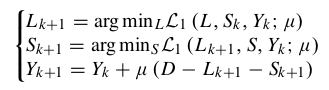

In [28]:
from IPython.display import Image
Image("subproblems.png")

where $\mathcal{L}_1$ is the augmented Lagrangian.


#### ~ Motion Saliency Map
The motion saliency map aims to remove background motion by setting $\lambda$ adaptively for different candidate foreground groups.

In a temporal slice, foreground motion will form a trajectory. The motion saliency map weighs candidate foreground groups by the number of trajectories passing through the group. Then, groups with a lower motion saliency weight are assigned a larger $\lambda$ value to reduce false detection.


#### ~ Second Pass: Group-Sparse RPCA

After setting the $\lambda$ values based on the motion saliency, a group-sparse version of RPCA is used to obtain the final background and foreground matrices. The group sparse RPCA optimization problem is given below, where $M_{i}$ is a matrix corresponding to a specific group and $\Vert . \Vert_{F}$ is the Frobenius norm. This convex optimization problem is again solved using the Augmented Lagrange Multiplier (ALM) method.

\begin{equation}
\min_{L,S} \Vert L \Vert_{\ast} + \sum_{i} \lambda_{i} \Vert M_{i} \Vert_{F} \quad s.t. \quad D=L+S
\end{equation}



The details of this algorithm can be found in:

-- Xin Liu, Guoying Zhao, Jiawen Yao, and Chun Qi. Background Subtraction Based on Low-Rank and Structured Sparse Decomposition. *IEEE Transactions on Image Processing*, 24(8):2502-2514, August 2015. ISSN 1057-7149, 1941-0042. doi:10.1109/TIP.2015.2419084

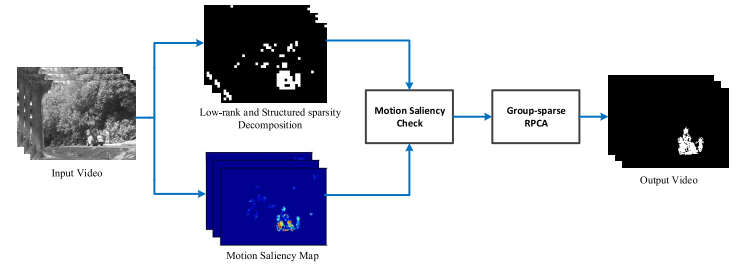

In [27]:
Image("figures/groupsparseframework.png") # Run this from the cvx-opt-project directory

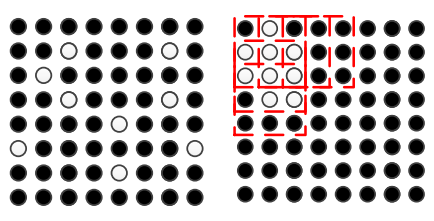

In [2]:
Image("figures/groups.png")

### 3- Fast RPCA

The last algorithm implemented is Fast RPCA. This method solves the RPCA problem using a non-convex approach by using a sparse estimator and a projected gradient method. The code for this algorithm can be found in *src/FRPCA_GD.py*. 

The details of this algorithm can be found in:

-- Xinyang Yi, Dohyung Park, Yudong Chen, and Constantine Caramanis. Fast algorithms for robust PCA via gradient descent. In *Advances in Neural Information Processing Systems*, pages 4152-4160, 2016.





In [11]:
from IPython.display import HTML, display
def display_anim(name):
    IMG_TAG = """<img src="data:image/gif;base64,{0}">"""
    data = open(name, "rb").read()
    data = data.encode("base64")
    return IMG_TAG.format(data)

#### GIFs of Results
These are generated using the following `imagemagick` command: 
```bash
convert -delay 10 -loop 0 foreground/*ity.gif ../structured_sparsity.gif
```

In [21]:
HTML(display_anim('structured_sparsity.gif'))

In [22]:
HTML(display_anim('rpca.gif'))

In [23]:
HTML(display_anim('l1.gif'))

In [5]:
from __future__ import print_function
import sys
import os

project_path = './'
video_name = ''
sys.path.append(project_path + 'src/')

In [6]:
import PIL.Image
import scipy
import scipy.sparse as sp
import scipy.io
import numpy as np
import numpy.linalg as la
import numpy.random as rn
import matplotlib.pyplot as plt

import frames as f
import graph as g
import motion as m
import group
from alm_lsd import inexact_alm_lsd, inexact_alm_bs

from FRPCA_GD import FRPCA
import cPickle as pickle
import os.path

In [7]:
# In order to read alternative data sources
def read_images(data_name):
    import glob
    import re
    
    def numericalSort(value):
        _numbers = re.compile(r'(\d+)')
        parts = _numbers.split(value)
        parts[1::2] = map(int, parts[1::2])
        return parts

    frame_path = project_path + 'data/' + data_name + '/'
    frames = []
    file_list = glob.glob(frame_path + "*.jpg")
    for file_names in sorted(file_list, key=numericalSort):
        image = PIL.Image.open(file_names)
        frame = np.asarray(image)
        frames.append(frame)
        
    return [0, len(frames)], np.array(frames)

In [8]:
def first_pass(frames_D, original_mean, frame_dimensions, downsampled_frame_dimensions, num_frames, norm_choice, verbose = True):
    if norm_choice == 'l1':
        print ('L1')
        background_L, foreground_S, err = inexact_alm_lsd(frames_D, None, 'l1', verbose = verbose)
        dims = downsampled_frame_dimensions
    elif norm_choice == 'structured_sparsity':
        print ('Structured Sparsity')
        batch_dimensions = [3, 3]
        graph = g.build_graph(downsampled_frame_dimensions, batch_dimensions)
        background_L, foreground_S, err = inexact_alm_lsd(frames_D, graph, 'structured_sparsity', verbose = verbose)
        dims = downsampled_frame_dimensions
    elif norm_choice == 'frpca':
        print ('FRPCA')
        background_L, foreground_S, err = FRPCA(frames_D, alpha = .3, r=1)
        dims = frame_dimensions
    else:
        raise ValueError('norm_choice is not valid.')

    # Masking first-RPCA foreground & Upsampling
    masked_S = f.foreground_mask(np.abs(foreground_S), frames_D, background_L)
    fg_frames = f.matrix_to_frames(masked_S, num_frames, dims)
    upsampled_fg = f.resize_frames(fg_frames, frame_dimensions)
    upsampled_fg = np.int32(upsampled_fg > 128) * 255

    # print
    bg_bin = f.restore_background(f.matrix_to_frames(background_L, num_frames,
                                                     dims), original_mean)
    bg_images = [PIL.Image.fromarray(frame) for frame in bg_bin]
    fg_images = [PIL.Image.fromarray(frame) for frame in upsampled_fg]
    for i in range(len(fg_images)):
        fg_images[i].save(project_path + "src/foreground_first_pass/out" + str(i) + norm_choice + ".gif")
        bg_images[i].save(project_path + "src/background_first_pass/out" + str(i) + norm_choice + ".gif")
    return upsampled_fg

In [ ]:
frame_index = [0, 48]
video_data_path = project_path + 'LSD/data/WaterSurface.mat'
all_frames = scipy.io.loadmat(video_data_path)['ImData']
start_frame_index = frame_index[0]
end_frame_index = frame_index[1]
frames_to_process = np.rollaxis(all_frames[:, :, start_frame_index:end_frame_index], 2)

if video_name is not '':
    frame_index, frames_to_process = read_images(video_name)
frame_dimensions = frames_to_process.shape[1:]

for norm_choice in ['l1', 'frpca', 'structured_sparsity']:
    print ('-------------------------------')
    norm_frame, one_pass_mean = f.normalize_and_center_frames(frames_to_process)
    one_pass_frames_D = f.frames_to_matrix(norm_frame, num_frames, frame_dimensions)
    upsampled_fg = first_pass(one_pass_frames_D, one_pass_mean, frame_dimensions, frame_dimensions, num_frames, norm_choice, True)


L1
('CPU Time(s): ', 5.996813824852779)
Structured Sparsity


In [15]:
HTML(display_anim('src/foreground_first_pass/out39structured_sparsity.gif'))

In [16]:
HTML(display_anim('src/foreground_first_pass/out39frpca.gif'))

In [17]:
HTML(display_anim('src/foreground_first_pass/out39l1.gif'))

In [ ]:
downsampling_ratio = 1.0 / 4.0
downsampled_frames = f.resize_frames(frames_to_process, downsampling_ratio)
downsampled_frame_dimensions = downsampled_frames.shape[1:]

num_frames = downsampled_frames.shape[0]
normalized_frames, original_mean = f.normalize_and_center_frames(downsampled_frames)

frames_D = f.frames_to_matrix(normalized_frames, num_frames, downsampled_frame_dimensions)

print ('---Identifying Trajectories with Optical Flow---')
backward_seq = np.flip(frames_to_process, 0)
if os.path.isfile('save.p'):
    trajectories_forward = pickle.load(open( "save.p", "rb" ))
    trajectories_backward = np.flip(trajectories_forward, 0)
else:
    # find trajectory
    optical_flows = m.calc_forward_backward_flow(frames_to_process)
    trajectories_forward = m.calc_trajectories(optical_flows[0], optical_flows[1], frame_dimensions, 5)
    optical_back = m.calc_forward_backward_flow(backward_seq)
    trajectories_backward = m.calc_trajectories(optical_back[0], optical_back[1], frame_dimensions, 5)
    pickle.dump(trajectories_forward, open( "save.p", "wb" ))
    
pixel_saliences = m.set_pixel_saliencies(trajectories_forward, trajectories_backward, video_data_dimensions)
    
for norm_choice in ['l1', 'structured_sparsity', 'frpca']:
    upsampled_fg = first_pass(frames_D, original_mean, downsampled_frame_dimensions, frame_dimensions, num_frames, norm_choice)
    print ('---Calculating Group Regularization Parameters---')
    # identify ground and compute lambda
    video_data_dimensions = [num_frames] + list(frame_dimensions)
    groups_info = group.find_groups(upsampled_fg, num_frames, upsampled_fg.shape[1:], min_size=50)
    m.set_groups_saliencies(groups_info, pixel_saliences)
    m.set_regularization_lambdas(groups_info, video_data_dimensions)

    print ('---Group Sparse RPCA---')
    # group sparse RPCA
    normalized_frames, original_mean = f.normalize_and_center_frames(frames_to_process)
    frames_D = f.frames_to_matrix(normalized_frames, num_frames, frame_dimensions)
    final_L, final_S, err = inexact_alm_bs(frames_D, groups_info)

    # finalize S, L
    final_bg = f.restore_background(f.matrix_to_frames(final_L, num_frames, frame_dimensions), original_mean)
    masked_fg = f.foreground_mask(np.abs(final_S), frames_D, final_L)
    final_fg = f.matrix_to_frames(masked_fg, num_frames, frame_dimensions)

    # print
    fg_images = [PIL.Image.fromarray(frame) for frame in final_fg]
    bg_images = [PIL.Image.fromarray(frame) for frame in final_bg]

    for i in range(len(fg_images)):
        fg_images[i].save(project_path + "src/foreground/out" + str(i).zfill(3) + norm_choice + ".gif")
        bg_images[i].save(project_path + "src/background/out" + str(i).zfill(3) + norm_choice + ".gif")

    bg_images[0].save(project_path + norm_choice + "bg_out.gif", save_all=True, append_images=bg_images[1:])
    fg_images[0].save(project_path + norm_choice + "fg_out.gif", save_all=True, append_images=fg_images[1:])

## After First Pass
After the first pass, we see many artifacts scattered throughout the foreground image. This is expected due to the slight motion in the background that cannot be absorbed into the background image since we assume the background is low rank. Removing the low rank assumption gives degraded performance, including some "ghosts" in the background image. 

In [18]:
HTML(display_anim('src/foreground/out39structured_sparsity.gif'))

In [19]:
HTML(display_anim('src/foreground/out39frpca.gif'))

In [20]:
HTML(display_anim('src/foreground/out39l1.gif'))

## Final Results
After the second pass, we see that most of the artifacts have been removed, and in all three cases we have a relatively smooth border on the foreground image.